## Single-cancer holdout prediction analysis

These experiments are meant to be a positive control: we're training and testing on the same gene in the same cancer type, evaluating how well our model can predict held-out positives and negatives.

If this doesn't work well within cancer types, we're probably wasting our time looking at prediction across genes and across cancer types.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

In [2]:
results_dir = os.path.join(cfg.repo_root,
                           'cross_cancer_flip_prop',
                           'cross_cancer_flip_labels2')
flip_labels_df = (
    au.load_flip_labels_results(results_dir, 'flip_labels')
      .sort_values(by=['train_identifier', 'test_identifier',
                       'percent_flip', 'signal'])
)
print(flip_labels_df.shape)
flip_labels_df.head(n=10)

(4128, 9)


,auroc,aupr,train_identifier,test_identifier,signal,seed,data_type,percent_flip,experiment
0,0.99564,0.944190,BRAF_COAD,BRAF_COAD,shuffled,42,train,0.1,flip_labels
1,0.96154,0.750000,BRAF_COAD,BRAF_COAD,shuffled,42,test,0.1,flip_labels
2,0.48072,0.074598,BRAF_COAD,BRAF_COAD,shuffled,42,cv,0.1,flip_labels
0,0.98990,0.806720,BRAF_COAD,BRAF_COAD,shuffled,3,train,0.1,flip_labels
1,0.57692,0.118590,BRAF_COAD,BRAF_COAD,shuffled,3,test,0.1,flip_labels
2,0.49242,0.072683,BRAF_COAD,BRAF_COAD,shuffled,3,cv,0.1,flip_labels
0,1.00000,1.000000,BRAF_COAD,BRAF_COAD,shuffled,2,train,0.1,flip_labels
1,0.15385,0.062271,BRAF_COAD,BRAF_COAD,shuffled,2,test,0.1,flip_labels
2,0.41529,0.057940,BRAF_COAD,BRAF_COAD,shuffled,2,cv,0.1,flip_labels
0,1.00000,1.000000,BRAF_COAD,BRAF_COAD,signal,3,train,0.1,flip_labels


In [3]:
# create one dataframe with original metrics, split by signal/shuffled
flip_orig_df = flip_labels_df[(flip_labels_df.data_type == 'test')]
flip_orig_df = (
    flip_orig_df.assign(gene=lambda x: x.train_identifier.str.split('_', expand=True)[0],
                        cancer_type=lambda x: x.train_identifier.str.split('_', expand=True)[1])
                .drop(columns=['train_identifier', 'test_identifier', 'data_type'])
                .reset_index(drop=True)
)
flip_orig_df.head()

,auroc,aupr,signal,seed,percent_flip,experiment,gene,cancer_type
0,0.96154,0.750000,shuffled,42,0.1,flip_labels,BRAF,COAD
1,0.57692,0.118590,shuffled,3,0.1,flip_labels,BRAF,COAD
2,0.15385,0.062271,shuffled,2,0.1,flip_labels,BRAF,COAD
3,0.63462,0.547620,signal,3,0.1,flip_labels,BRAF,COAD
4,0.67308,0.552630,signal,2,0.1,flip_labels,BRAF,COAD


In [4]:
# create another dataframe with difference between signal and shuffled
flip_norm_df = au.normalize_to_control(flip_labels_df,
                                       train_id='train_identifier',
                                       test_id='test_identifier',
                                       additional_cols=['percent_flip', 'seed'])
flip_norm_df = (
    flip_norm_df.assign(gene=lambda x: x.train_identifier.str.split('_', expand=True)[0],
                        cancer_type=lambda x: x.train_identifier.str.split('_', expand=True)[1])
                .drop(columns=['train_identifier', 'test_identifier'])
                .reset_index(drop=True)
)
flip_norm_df.head()

,percent_flip,seed,aupr,gene,cancer_type
0,0.90,42,0.050100,TP53,GBM
1,0.25,42,-0.482511,EGFR,UCEC
2,0.95,2,0.097430,KRAS,LUAD
3,0.50,42,-0.055576,EGFR,UCEC
4,0.75,42,0.008502,EGFR,UCEC


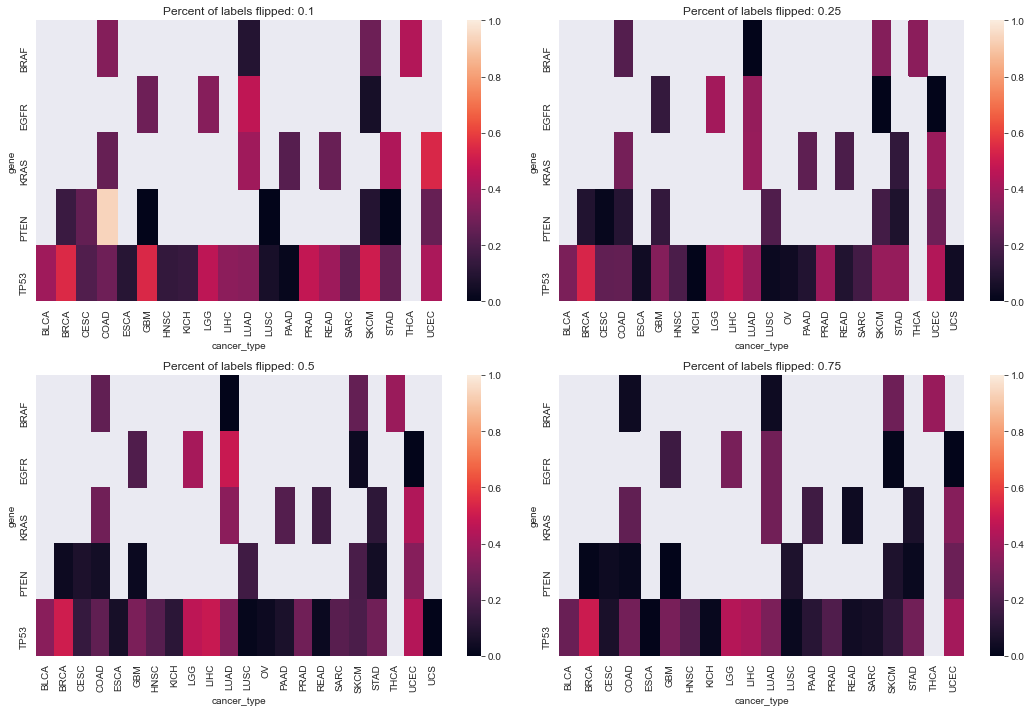

In [5]:
sns.set({'figure.figsize': (15, 10)})
fig, axarr = plt.subplots(2, 2)

# need to take mean over seeds for heatmap
heatmap_cols_df = (
    flip_norm_df.groupby(['gene', 'cancer_type', 'percent_flip'], as_index=False)
                .mean()
                .drop(columns=['seed'])
)

percents_flip = np.sort(heatmap_cols_df.percent_flip.unique())[:4]
for ix, percent_flip in enumerate(percents_flip):
    ax = axarr[ix // 2, ix % 2] 
    heatmap_df = (
        heatmap_cols_df.query('percent_flip == @percent_flip')
                       .pivot(index='gene', columns='cancer_type', values='aupr')
    )
    sns.heatmap(heatmap_df, vmin=0.0, vmax=1.0, ax=ax)
    ax.set_title('Percent of labels flipped: {}'.format(percent_flip))
plt.tight_layout()

The above heatmap shows predictive performance for varying percentage of held-out data (10%, 20%, 30%, 50%) and for several genes/cancer types. Takeaways:

1. Performance looks fairly good for many genes and cancer types (TP53, KRAS, BRAF most of the time) but not so good for others (PTEN)
2. Performance is fairly stable across percentages of data held out, which indicates that this evaluation scheme makes more sense than just flipping positive labels (past attempts weren't at all consistent/stable).

In [6]:
flip_orig_df['identifier'] = flip_orig_df.gene + '_' + flip_orig_df.cancer_type
flip_orig_df.head()

,auroc,aupr,signal,seed,percent_flip,experiment,gene,cancer_type,identifier
0,0.96154,0.750000,shuffled,42,0.1,flip_labels,BRAF,COAD,BRAF_COAD
1,0.57692,0.118590,shuffled,3,0.1,flip_labels,BRAF,COAD,BRAF_COAD
2,0.15385,0.062271,shuffled,2,0.1,flip_labels,BRAF,COAD,BRAF_COAD
3,0.63462,0.547620,signal,3,0.1,flip_labels,BRAF,COAD,BRAF_COAD
4,0.67308,0.552630,signal,2,0.1,flip_labels,BRAF,COAD,BRAF_COAD


In [7]:
flip_norm_df['identifier'] = flip_norm_df.gene + '_' + flip_norm_df.cancer_type
flip_norm_df.head()

,percent_flip,seed,aupr,gene,cancer_type,identifier
0,0.90,42,0.050100,TP53,GBM,TP53_GBM
1,0.25,42,-0.482511,EGFR,UCEC,EGFR_UCEC
2,0.95,2,0.097430,KRAS,LUAD,KRAS_LUAD
3,0.50,42,-0.055576,EGFR,UCEC,EGFR_UCEC
4,0.75,42,0.008502,EGFR,UCEC,EGFR_UCEC


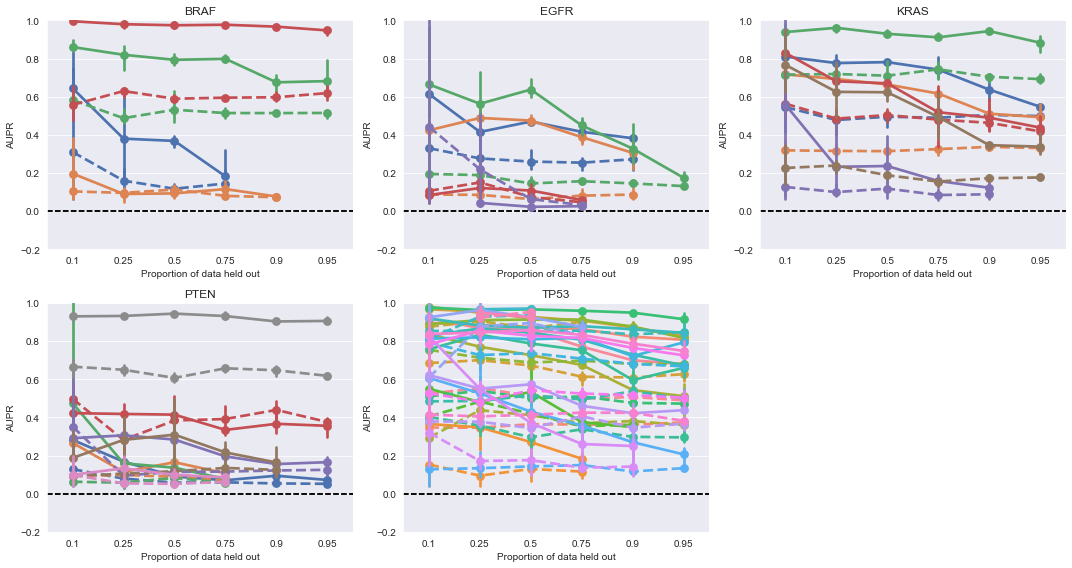

In [8]:
plot_genes = np.sort(flip_orig_df.gene.unique())
sns.set({'figure.figsize': (15, 8)})
fig, axarr = plt.subplots(2, 3)
for signal in ['signal', 'shuffled']:
    for ix, plot_gene in enumerate(plot_genes):
        ax = axarr[ix // 3, ix % 3] 
        plot_df = (
            flip_orig_df[(flip_orig_df.gene == plot_gene) & (flip_orig_df.signal == signal)].sort_values(by='cancer_type')
        )
        linestyle = '--' if signal == 'shuffled' else '-'
        sns.pointplot(data=plot_df, x='percent_flip', y='aupr', hue='identifier', linestyles=linestyle, ax=ax)
        ax.set_xlabel('Proportion of data held out')
        ax.set_ylabel('AUPR')
        ax.set_ylim(-0.2, 1.0)
        ax.set_title(plot_gene)
        ax.get_legend().remove()
        ax.axhline(y=0, color='black', linestyle='--')
fig.delaxes(axarr[1, 2])
plt.tight_layout()
# is there a way to show info about cancer types?

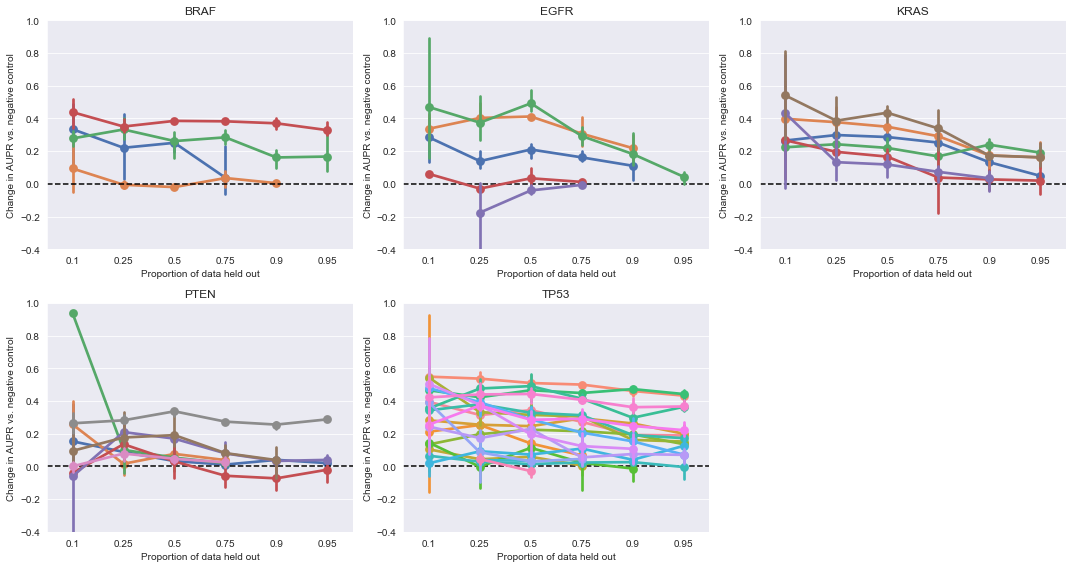

In [9]:
plot_genes = np.sort(flip_norm_df.gene.unique())
sns.set({'figure.figsize': (15, 8)})
fig, axarr = plt.subplots(2, 3)
for ix, plot_gene in enumerate(plot_genes):
    ax = axarr[ix // 3, ix % 3] 
    plot_df = (
        flip_norm_df[flip_norm_df.gene == plot_gene].sort_values(by='cancer_type')
    )
    sns.pointplot(data=plot_df, x='percent_flip', y='aupr', hue='identifier', ax=ax)
    ax.set_xlabel('Proportion of data held out')
    ax.set_ylabel('Change in AUPR vs. negative control')
    ax.set_ylim(-0.4, 1.0)
    ax.set_title(plot_gene)
    ax.get_legend().remove()
    ax.axhline(y=0, color='black', linestyle='--')
fig.delaxes(axarr[1, 2])
plt.tight_layout()
# is there a way to show info about cancer types?

The line plots above are just another way to visualize trends as more data is moved to the test set. Each plot is a gene, each line is a cancer type. 

We're a bit surprised we don't see more performance degradation as the proportion of held-out data gets closer to 1. Could be that the genes that we picked just have very strong signal (e.g. TP53 is very easily predictable, we know this already).

In [13]:
reduced_df = (
    flip_norm_df[flip_norm_df.percent_flip == 0.95]
      .groupby(['identifier', 'gene', 'cancer_type', 'percent_flip'], as_index=False)
      .mean()
      .drop(columns=['seed'])
)
reduced_df.head()

,identifier,gene,cancer_type,percent_flip,aupr
0,BRAF_SKCM,BRAF,SKCM,0.95,0.166927
1,BRAF_THCA,BRAF,THCA,0.95,0.328613
2,EGFR_LUAD,EGFR,LUAD,0.95,0.043060
3,KRAS_COAD,KRAS,COAD,0.95,0.048973
4,KRAS_LUAD,KRAS,LUAD,0.95,0.161960


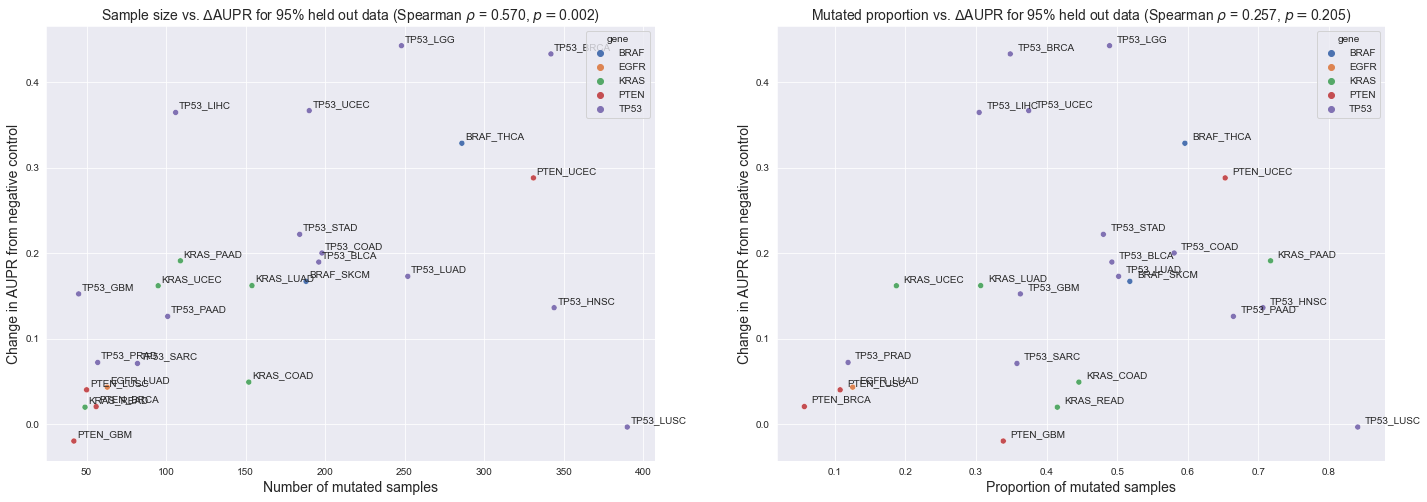

In [14]:
from scipy.stats import spearmanr

sns.set({'figure.figsize': (24, 8)})
fig, axarr = plt.subplots(1, 2)

def label_points(x, y, x_offset, y_offset, gene, ax):
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene})
    for i, point in a.iterrows():
        ax.text(point['x']+x_offset, point['y']+y_offset, str(point['gene']))

proportion_df = au.get_proportion_info(reduced_df, results_dir)
sns.scatterplot(data=proportion_df, x='status_count', y='aupr', hue='gene', ax=axarr[0])
rho, pval = spearmanr(proportion_df.status_count, proportion_df.aupr)
axarr[0].set_xlabel('Number of mutated samples', fontsize=14)
axarr[0].set_ylabel('Change in AUPR from negative control', fontsize=14)
axarr[0].set_title(r'Sample size vs. $\Delta$AUPR for 95% held out data (Spearman $\rho$ = {:.3f}, $p = ${:.3f})'.format(rho, pval), fontsize=14)
label_points(proportion_df.status_count, proportion_df.aupr, 2, 0.005, proportion_df.identifier, axarr[0])

sns.scatterplot(data=proportion_df, x='status_proportion', y='aupr', hue='gene', ax=axarr[1])
rho, pval = spearmanr(proportion_df.status_proportion, proportion_df.aupr)
axarr[1].set_xlabel('Proportion of mutated samples', fontsize=14)
axarr[1].set_ylabel('Change in AUPR from negative control', fontsize=14)
axarr[1].set_title(r'Mutated proportion vs. $\Delta$AUPR for 95% held out data (Spearman $\rho$ = {:.3f}, $p = ${:.3f})'.format(rho, pval), fontsize=14)
label_points(proportion_df.status_proportion, proportion_df.aupr, 0.01, 0.005, proportion_df.identifier, axarr[1])

In the plot above we wanted to see if the performance with most data held out (around 95%) correlates with the overall number of mutated samples (i.e. the absolute number of 1 labels) or with the proportion of mutated samples.

We can see that performance does correlate fairly strongly with the number of mutated samples (but not so much the proportion), showing that some of the positive performance can be attributed to just having lots of data (relatively speaking) for these particular examples.